# Preparing dataset

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score

from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, mean_squared_error

In [ ]:
#importing dataset
dta1 = np.load('trainspotting_dataset/data/train_1.npy').view(np.recarray)
dta2 = np.load('trainspotting_dataset/data/train_2.npy').view(np.recarray)
lbl1 = np.load('trainspotting_dataset/data/train_1_lbl.npy')
lbl2 = np.load('trainspotting_dataset/data/train_2_lbl.npy')

# The 'dta' variables now hold a record array with following columns:
#   dta.t - time stamp in ordinal format
#   dta.d - runlength encoding - delta values
#   dta.x - accelerometer X-axis
#   dta.y - accelerometer Y-axis
#   dta.z - accelerometer Z-axis
#   dta.l - ambient light sensor

# The 'lbl' variables hold the start and stop time indices of the event, as well
# as the train type ID (main track) or the number of wagons (regional track).

# load detailed annotations for main track
#~ timetable = mlab.csv2rec('data/timetable.csv',delimiter=';')
traintypes = {1:'ICE', 2: 'IC', 3: 'EC', 4: 'Cargo', 5: 'RE', 6: 'RB'}

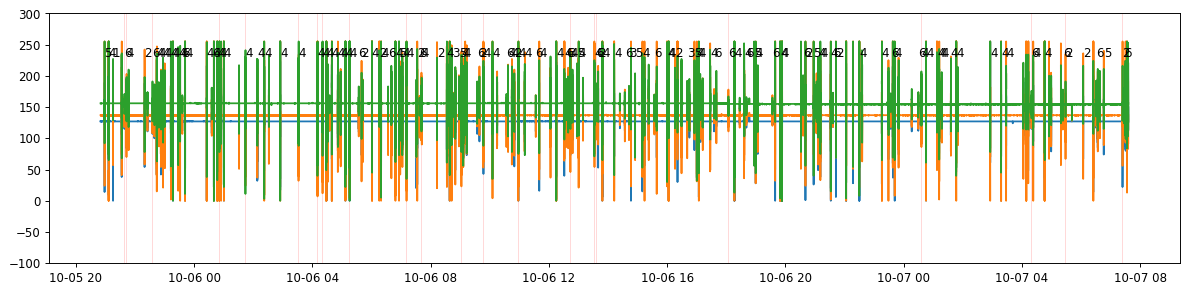

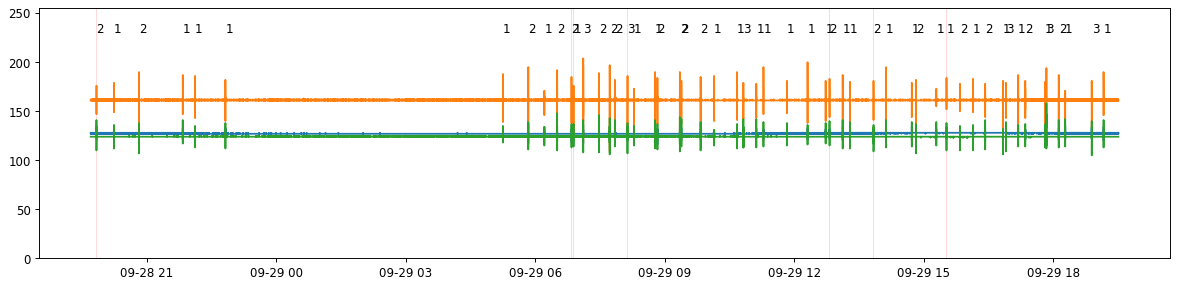

In [ ]:
# plot main track data and mark annotated (known) trains
fig = plt.figure(num=None,figsize=(14,3.5),dpi=85,facecolor='w',edgecolor='k')
ax1 = plt.subplot(1,1,1)
ax1.plot_date( dta1.t , np.array((dta1.x,dta1.y,dta1.z)).T , '-')
plt.ylim([-100,300])
for s,e,l in lbl1:
    ax1.axvspan( dta1.t[s], dta1.t[e], facecolor='r', alpha=0.15)
    ax1.text(dta1.t[s],230, l)
plt.subplots_adjust(left=0.04,right=0.99,bottom=0.09,top=0.93,wspace=0.05,hspace=0.1)
plt.show()

# plot city hopper track data
fig = plt.figure(num=None,figsize=(14,3.5),dpi=85,facecolor='w',edgecolor='k')
ax1 = plt.subplot(1,1,1)
plt.plot_date( dta2.t , np.array((dta2.x,dta2.y,dta2.z)).T , '-')
plt.ylim([0,255])
for s,e,l in lbl2:
    ax1.axvspan( dta2.t[s], dta2.t[e], facecolor='r', alpha=0.15)
    ax1.text(dta2.t[s],230,l)
plt.subplots_adjust(left=0.04,right=0.99,bottom=0.09,top=0.93,wspace=0.05,hspace=0.1)
plt.show()

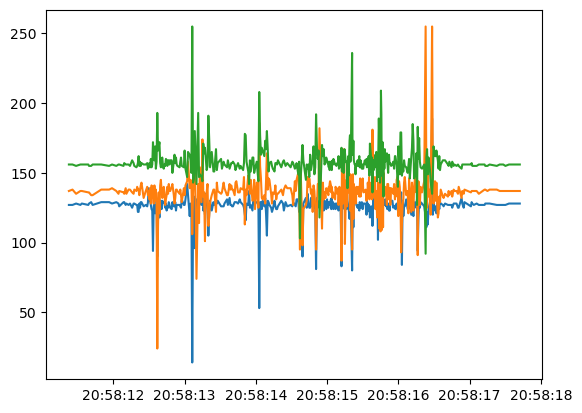

In [ ]:
presentation_period_start = 225
presentation_period_end = 640
plt.ion()
plt.plot_date( dta1.t[presentation_period_start:presentation_period_end], np.array(
    (dta1.x[presentation_period_start:presentation_period_end],
     dta1.y[presentation_period_start:presentation_period_end],
     dta1.z[presentation_period_start:presentation_period_end])).T , '-')

# plt.ylim([-10,255])

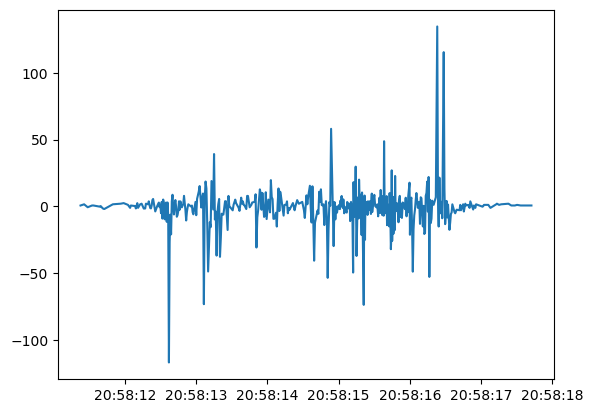

In [ ]:
# not used

def combine_acceleration_by_rsm(x, y, z):
    num_elements = len(x)
    accelerations = []

    for i in range(num_elements):
        acceleration = np.sqrt((x[i]**2 + y[i]**2 + z[i]**2)/3)
        accelerations.append(acceleration)

    return np.array(accelerations)

def combine_acceleration_by_pca(x, y, z):
    num_elements = len(x)
    accelerations = []

    # Combine measures into a matrix
    measures_matrix = np.vstack((x, y, z)).T

    # Apply PCA
    pca = PCA(n_components=1)
    accelerations = pca.fit_transform(measures_matrix)

    return np.array(accelerations)

combined_accelerations = combine_acceleration_by_pca(dta1.x, dta1.y, dta1.z)

plt.plot_date( dta1.t[presentation_period_start:presentation_period_end], combined_accelerations[presentation_period_start:presentation_period_end] , '-')

In [ ]:
def sliding_window_variance(x, y, z, window_size):
    num_elements = len(x)
    variances = []

    for i in range(num_elements):
        if(i < num_elements - window_size + 1):
            window_x = x[i:i+window_size]
            window_y = y[i:i+window_size]
            window_z = z[i:i+window_size]
        else:
            window_x = x[i:num_elements]
            window_y = y[i:num_elements]
            window_z = z[i:num_elements]

        variance = (np.var(window_x)+np.var(window_y)+np.var(window_z))/3
        variances.append(variance)

    return np.array(variances)

window_size = 10
variances = sliding_window_variance(dta1.x, dta1.y, dta1.z, window_size)

325075


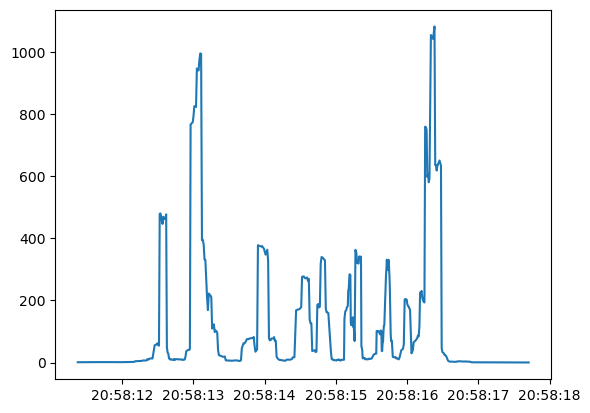

In [ ]:
print(len(variances))

plt.ion()
plt.plot_date( dta1.t[presentation_period_start:presentation_period_end], variances[presentation_period_start:presentation_period_end], '-')
plt.show()

In [ ]:
#trying to detect the start and end of the events of the trainspotting

def get_start_and_end(indices):
    start_indices = []
    end_indices = []

    i = 1
    while(i < len(indices)):
        start_indices.append(indices[i])
        i = i+1

        while(i < len(indices) and indices[i] == indices[i - 1] + 1):
            i = i+1

        end_indices.append(indices[i-1])

    return np.array(start_indices), np.array(end_indices)

def estimate_period_start_end(data, threshold_factor):

    mean = np.mean(data)
    threshold = threshold_factor * mean

    above_threshold = []

    for index in range(len(data)):
        if (data[index] > threshold):
            above_threshold.append(index)

    return get_start_and_end(above_threshold)


start, end = estimate_period_start_end(variances, 1.5)

print("Estimated Start:", start)
print("Estimated End:", end)

Estimated Start: [   265    303    361 ... 324366 324766 324964]
Estimated End: [   273    317    370 ... 324369 324775 324968]


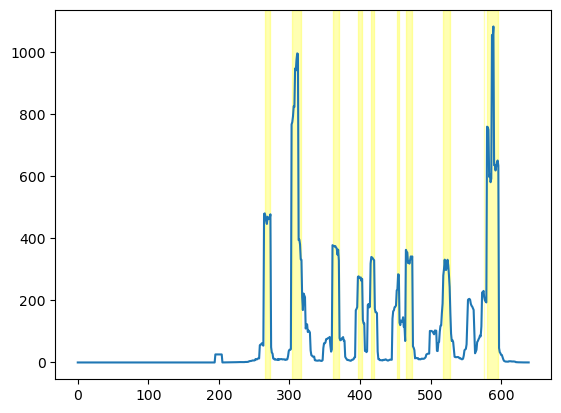

In [ ]:
plt.ion()
plt.plot(variances[0:presentation_period_end], '-')

for i in range(10):
    plt.axvspan(start[i], end[i], color='yellow', alpha=0.3, label='Highlighted Span')

In [ ]:
def estimate_peak_start_end(data, threshold_factor=1.5, window_size = 15):
    data_mean = np.mean(data)
    threshold = threshold_factor * data_mean

    starts = []
    ends = []


    index = 0
    while(index < len(data)):
        window = data[index : index + window_size]
        window_mean = np.mean(window)

        if(window_mean > threshold):
            starts.append(index)

            while(index < len(data)and window_mean > threshold):
                index = index+1
                window = data[index : index + window_size]
                window_mean = np.mean(window)

            ends.append(index + window_size)

        index = index + window_size + 1

    return starts, ends

window_size = 300
starts_peak, ends_peak = estimate_peak_start_end(variances, 1.5, window_size)
print("Estimated Start:", len(starts_peak) )
print("Estimated End:", len(ends_peak) )

def estimate_zeros_start_end(data, tolerance = 10, window_size = 15):
    starts = []
    ends = []

    index = 0
    while(index < len(data)):
        window = data[index : index + window_size]
        window_mean = np.mean(window)

        if(window_mean <= tolerance):
            starts.append(index)

            while(index < len(data)and window_mean <= tolerance):
                index = index+1
                window = data[index : index + window_size]
                window_mean = np.mean(window)

            ends.append(index + window_size)

        index = index + window_size + 1
    return starts, ends

starts_zero, ends_zero = estimate_zeros_start_end(variances, 200, 5)
print("Estimated Start:", len(starts_zero) )
print("Estimated End:", len(ends_zero) )

Estimated Start: 79
Estimated End: 79
Estimated Start: 2898
Estimated End: 2898


C:\Users\Public\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Public\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


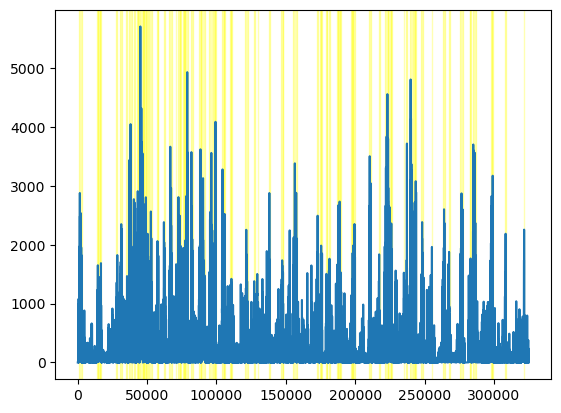

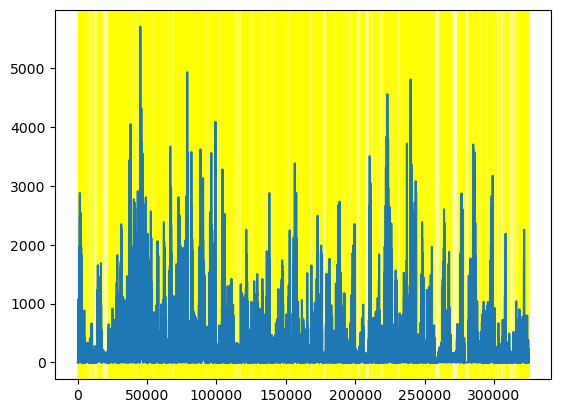

In [ ]:
plt.plot(variances, '-')

for i in range(len(starts_peak)):
    plt.axvspan(starts_peak[i], ends_peak[i], color='yellow', alpha=0.3, label='Highlighted Span')
plt.show()

plt.plot(variances, '-')

for i in range(len(starts_zero)):
    plt.axvspan(starts_zero[i], ends_zero[i], color='yellow', alpha=0.3, label='Highlighted Span')
plt.show()

Feature engineering
1. Mean
2. Amplitude (max value)
3. Root mean square (RMS)
4. Duration
5. Number of peaks
6. Zero crossing rate
7. Peak-to-peak values (max - min)
8. Mean of peak values
9. Variance of peak values


In [ ]:
train_events = []
labels = []

for s,e,l in lbl1:
    event = variances[s:e]
    train_events.append(event)
    labels.append(l)

means = []
amplitudes = []
rms = []
durations = []

number_of_peaks = []
zero_crossing_rate = []

peak_range = []
peak_mean = []
peak_std_dev = []

for event in train_events:
    means.append( np.mean(event) )
    amplitudes.append( max(event) )
    rms.append( np.std(event) )
    durations.append( len(event) )

    starts_peak, ends_peak = estimate_peak_start_end(event, 2.0, 5)
    number_of_peaks.append( len(starts_peak) )

    starts_zero, ends_zero = estimate_zeros_start_end(event, 200, 5)
    zero_crossing_rate.append( len(starts_zero) )

    peak_values = []
    for i in range(len(starts_peak)):
        peak_values.append(max(event[starts_peak[i]:ends_peak[i]]))

    peak_range.append(max(peak_values) - min(peak_values))
    peak_mean.append(np.mean(peak_values))
    peak_std_dev.append(np.std(peak_values))

features = pd.DataFrame(
    {
     'mean':means,
     'amplitude': amplitudes,
     'rms': rms,
     'duration': durations,

     'number_of_peaks': number_of_peaks,
     'zero_crossing_rate':zero_crossing_rate,
     'peak-to-peak_value':peak_range,
     'peaks_mean':peak_mean,
     'peaks_standard_deviation':peak_std_dev
    }
)

print(features)

C:\Users\Public\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Public\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


           mean    amplitude         rms  duration  number_of_peaks  \
0    142.316810  1081.803333  210.745557       418                7   
1    466.631509  2882.163333  520.736658      1988               25   
2     92.949301   644.526667  147.355876       248                3   
3     13.556294    77.216667   14.674261       528                5   
4     70.957358   336.300000   57.141887      2528               23   
..          ...          ...         ...       ...              ...   
130  124.137573   724.913333  156.643495       309                5   
131   13.668431    86.340000   14.995957       478                4   
132   67.367739   519.110000  106.116653       370                4   
133   96.403192  1040.683333  174.192307       426                5   
134   17.627571    65.696667   16.451498       424                6   

     zero_crossing_rate  peak-to-peak_value   peaks_mean  \
0                    11          750.746667   565.686190   
1                    40    

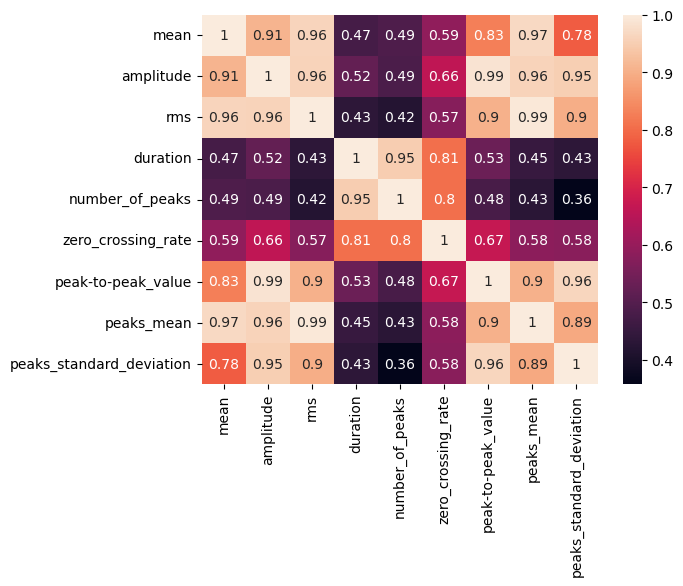

In [ ]:
import seaborn as sns
cor = features.corr()

plt.figure()
sns.heatmap(cor, annot = True)
plt.show()

Feature: 0, Score: 0.00509
Feature: 1, Score: -0.00287
Feature: 2, Score: 0.00230
Feature: 3, Score: 0.00052
Feature: 4, Score: -0.05364
Feature: 5, Score: -0.01453
Feature: 6, Score: 0.00398
Feature: 7, Score: -0.00046
Feature: 8, Score: -0.00481


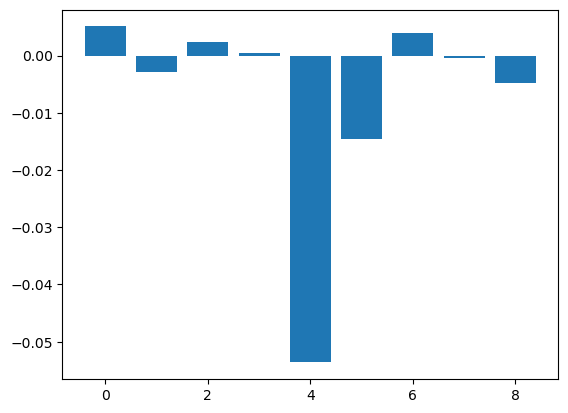

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

chi2_features = SelectKBest(chi2, k = 3)
kbest_features = chi2_features.fit_transform(features, labels)

# print(kbest_features)

# linear regression feature importance
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot
# define dataset
X, y = make_regression(n_samples=135, n_features=9, n_informative=5, random_state=1)
# define the model
model = LinearRegression()
# fit the model
model.fit(features, labels)
# get importance
importance = model.coef_
# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

# Split to train and test


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=40)

In [ ]:
# Standardize features (important for Logistic Regression)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Cross-validation and evaluation


In [ ]:
#SVM model with sigmoid function
svm_model_poly = SVC(kernel='poly', C=1.0)

#SVM model with sigmoid function
svm_model_sigmoid = SVC(kernel='sigmoid', C=1.0)

#SVM model with radial basis function
svm_model_rbf = SVC(kernel='rbf', C=1.0)

#KNN model
n_neighbors = 5
knn_model = KNeighborsClassifier(n_neighbors=n_neighbors)

#Logistic regression model
logreg_model = LogisticRegression(multi_class='multinomial')

In [ ]:
# executing cross validation
k_folds = KFold(n_splits = 5)

knn_scores = cross_val_score(knn_model, X_train, y_train, cv = k_folds)
poly_svm_scores = cross_val_score(svm_model_poly, X_train, y_train, cv = k_folds)
sigmoid_svm_scores = cross_val_score(svm_model_sigmoid, X_train, y_train, cv = k_folds)
rbf_svm_scores = cross_val_score(svm_model_rbf, X_train, y_train, cv = k_folds)
logreg_scores = cross_val_score(logreg_model, X_train, y_train, cv = k_folds)

In [ ]:
print("Cross validation scores:")
print("KNN", knn_scores, "\nAverage", np.mean(knn_scores))
print("\nSVM poly", poly_svm_scores, "\nAverage",np.mean(poly_svm_scores))
print("\nSVM sigmoid", sigmoid_svm_scores,"\nAverage", np.mean(sigmoid_svm_scores))
print("\nSVM rbf", rbf_svm_scores,"\nAverage", np.mean(rbf_svm_scores))
print("\nLogistic regression", logreg_scores,"\nAverage", np.mean(logreg_scores))

Cross validation scores:
KNN [0.90909091 0.90909091 0.72727273 0.76190476 0.85714286] 
Average 0.8329004329004329

SVM poly [0.90909091 0.90909091 0.59090909 0.76190476 0.85714286] 
Average 0.8056277056277056

SVM sigmoid [0.86363636 0.81818182 0.59090909 0.71428571 0.9047619 ] 
Average 0.7783549783549784

SVM rbf [0.90909091 0.81818182 0.77272727 0.80952381 0.9047619 ] 
Average 0.8428571428571429

Logistic regression [0.90909091 0.81818182 0.72727273 0.80952381 0.85714286] 
Average 0.8242424242424242


In [ ]:
logreg_model.fit(X_train, y_train)

# make predictions on test data
y_pred = logreg_model.predict(X_test)

In [ ]:
print(np.array(y_pred) )
print(np.array(y_test) )

# evaluate the final model
mse = mean_squared_error(y_test, y_pred)

accuracy = np.mean(y_pred == y_test)
precision = precision_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, y_pred, average='micro')
# roc_auc = roc_auc_score(y_test, y_pred, average='micro', multi_class='ovo')

print(f"Mean Squared Error: {mse}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

[4 4 6 4 4 6 5 4 4 6 5 4 4 2 4 6 4 4 4 6 4 4 6 4 4 4 4]
[4 4 6 4 4 6 2 4 4 6 2 4 4 1 4 6 4 4 4 6 4 4 6 4 4 4 4]
Mean Squared Error: 0.7037037037037037
Accuracy: 0.8888888888888888
Precision: 0.8888888888888888
Recall: 0.8888888888888888
